In [53]:
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.autograd import Function
from utils import*
from detection_output import Detect
from prior_box import PriorBox
from l2norm import L2norm as L2norm
from model import build_ssd
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.serialization import load_lua
from f_l2norm import L2norm as norm
import PIL
from PIL import Image


In [54]:
net = build_ssd()

In [7]:
img = load_lua('data/img9505.t7').float()
ssd = load_lua('../PyTorchProjects/pytorch-ssd/VOC.t7')
norm_weights = load_lua('weights/normWeights.t7')

In [9]:
# imsize = 300
# loader = transforms.Compose([
#            # transforms.Scale(imsize),# scale imported image
#            # transforms.CenterCrop(imsize),
#             transforms.ToTensor()]) # transform it into a torch tensor

# def image_loader(image_name):
#     image = Image.open(image_name)
#     image = loader(image)
#     #image = image.unsqueeze(0) # fake batch dimension required to fit network's input dimensions
#     return image



In [10]:
pytorch_modules = list(net.modules())
next_pytorch_idx = 0
for i, t7_module in enumerate(ssd.modules):
    if not hasattr(t7_module, 'weight'):
        continue
    assert hasattr(t7_module, 'bias')
    while not hasattr(pytorch_modules[next_pytorch_idx], 'weight'):
        next_pytorch_idx += 1
    pytorch_module = pytorch_modules[next_pytorch_idx]
    next_pytorch_idx += 1
    if(pytorch_module.weight.data.dim() == 1):
        pytorch_module = pytorch_modules[next_pytorch_idx]
        next_pytorch_idx += 1
    print(t7_module.weight.size())
    print(pytorch_module.weight.data.size())
    assert(t7_module.weight.size() == pytorch_module.weight.size())
    print('%r Copying data from\n  %r to\n  %r' % (i, t7_module, pytorch_module))

    pytorch_module.weight.data.copy_(t7_module.weight)
    assert(t7_module.bias.size() == pytorch_module.bias.size())
    pytorch_module.bias.data.copy_(t7_module.bias)
pytorch_modules[-14].weight.data.copy_(norm_weights);

torch.Size([64, 3, 3, 3])
torch.Size([64, 3, 3, 3])
0 Copying data from
  nn.SpatialConvolution(3 -> 64, 3x3, 1, 1, 1, 1) to
  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
2 Copying data from
  nn.SpatialConvolution(64 -> 64, 3x3, 1, 1, 1, 1) to
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 64, 3, 3])
torch.Size([128, 64, 3, 3])
5 Copying data from
  nn.SpatialConvolution(64 -> 128, 3x3, 1, 1, 1, 1) to
  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
7 Copying data from
  nn.SpatialConvolution(128 -> 128, 3x3, 1, 1, 1, 1) to
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([256, 128, 3, 3])
torch.Size([256, 128, 3, 3])
10 Copying data from
  nn.SpatialConvolution(128 -> 256, 3x3, 1, 1, 1, 1) to
  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
tor

In [12]:
detections = net(Variable(img),'test')

7.894736842105263
7.894736842105263
15.789473684210526
15.789473684210526
30.0
30.0
60.0
60.0
100.0
100.0
300.0
300.0
torch.Size([7308, 21])
torch.Size([1, 21, 7308])
torch.Size([7308, 4])
yo
hi
torch.Size([200])


In [39]:
detections = detections.data
det_label = detections[0,:,1]
det_conf = detections[0,:,2]
det_xmin = detections[0,:,3]
det_ymin = detections[0,:,4]
det_xmax = detections[0,:,5]
det_ymax = detections[0,:,6]



def top_vals(values): # Get detections with confidence higher than 0.6.
    cutOff = []
    for i in range(values.size(0)):
        if det_conf[i] > 0.9:
            cutOff.append(values[i]) 
        
     
    return cutOff

    
top_conf = top_vals(det_conf)
top_labels = top_vals(det_label)
top_xmin = top_vals(det_xmin)
top_ymin = top_vals(det_ymin)
top_xmax = top_vals(det_xmax)
top_ymax = top_vals(det_ymax)

In [41]:
import matplotlib.pyplot as plt



import matplotlib.patches as patches
from PIL import Image


im = np.array(Image.open('data/IMG_9505.jpg'), dtype=np.uint8)

#

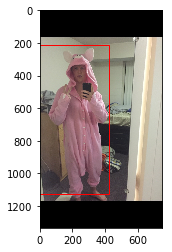

In [49]:
xmin = int(round(top_xmin[0] * im.shape[1]))
ymin = int(round(top_ymin[0] * im.shape[0]))
xmax = int(round(top_xmax[0] * im.shape[1]))
ymax = int(round(top_ymax[0] * im.shape[0]))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((xmax,ymin),xmax-xmin+1,ymax-ymin+1,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# for i in range(len(top_conf)):
#     xmin = int(round(top_xmin[i] * im.shape[1]))
#     ymin = int(round(top_ymin[i] * im.shape[0]))
#     xmax = int(round(top_xmax[i] * im.shape[1]))
#     ymax = int(round(top_ymax[i] * im.shape[0]))
#     score = top_conf[i]
#     label = int(top_labels[i])
#     label_name = top_labels[i]
#     display_txt = '%s: %.2f'%(label_name, score)
#     coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
#     color = colors[label]
#     currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
#     currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
#     plt.show()

In [ ]:
import os
cwd = os.getcwd()